In [1]:
import datetime
import Image
import gc
import numpy as np
import os
import random
from scipy import misc
import string
import time
import sys
import sklearn.metrics as skm

# Set some Theano config before initializing
os.environ["THEANO_FLAGS"] = "mode=FAST_RUN,device=cpu,floatX=float32,allow_gc=False,openmp=True"
import theano

# MatPlotLib - Setup for Jupyter notebook output
import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt

# Our modules
import dwdii_bc_model_helper as bc
import bc_models as models

# And Keras so we can emit the version
import keras

random.seed(20275)
np.set_printoptions(precision=2)

/usr/lib/python2.7/dist-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/usr/lib/python2.7/dist-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/usr/lib/python2.7/dist-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/usr/lib/python2.7/dist-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/usr/lib/python2.7/dist-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scipy.linalg.blas instead
  DeprecationWarning)
/usr/lib/python2.7/dist-packages/scipy/lib/_util.py:35: DeprecationWarning: Module scipy.linalg.blas.fblas is deprecated, use scip

In [2]:
# Print some upfront version and config settings
print "Python v" + sys.version
print "keras v: " + keras.__version__
print "device:", theano.config.device
print "floatX:",  theano.config.floatX
print "mode:", theano.config.mode
print "openmp:", theano.config.openmp
print "allow_gc:", theano.config.allow_gc

Python v2.7.6 (default, Jun 22 2015, 17:58:13) 
[GCC 4.8.2]
keras v: 1.0.3
device: cpu
floatX: float32
mode: FAST_RUN
openmp: True
allow_gc: False


In [3]:
imagePath = "/root/bc_data/ddsm-png.25"
#imagePath = "/root/bc_data/Data_Thresholded/DDSM"
trainDataPath = "../../data/ddsm_train.csv"
testDataPath = "../../data/ddsm_test.csv"
imgResize = (150, 150)

In [4]:
os.listdir('../../data')

/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:672: DeprecationWarning: PlainTextFormat

['ddsm_test.csv', 'ddsm_train.csv', 'ddsm_val.csv', 'mias_all.csv']

# Load Training and Test Data

In this section, the training/validation data is loaded. The load_data function pre-balances the data set by removing images from over-represented emotion classes.

### Training Data

In [5]:
metaData, meta2, mCounts = bc.load_training_metadata(trainDataPath, balanceViaRemoval=True, verbose=True)

Raw Balance
----------------
benign 541
malignant 852
normal 2793
balanaceViaRemoval.avgE: 1395
balanaceViaRemoval.theshold: 1395.0

After Balancing
----------------
benign 541
malignant 852
normal 929


In [6]:
# Actually load some representative data for model experimentation
maxData = len(metaData)
X_data, Y_data = bc.load_data(trainDataPath, imagePath, maxData = maxData, verboseFreq = 50, imgResize=imgResize)
print X_data.shape
print Y_data.shape

Raw Balance
----------------
benign 541
malignant 852
normal 2793
balanaceViaRemoval.avgE: 1395
balanaceViaRemoval.theshold: 1395.0

After Balancing
----------------
benign 541
malignant 852
normal 929


dwdii_bc_model_helper.py:161: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  X_data = np.zeros([total, x, y])
dwdii_bc_model_helper.py:162: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_data = np.zeros([total, 1], dtype=np.int8)


0.0000: A_0526_1.LEFT_CC.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1146_1.LEFT_MLO.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1211_1.LEFT_CC.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1190_1.LEFT_CC.LJPEG.png
0.0215: B_3031_1.LEFT_MLO.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1159_1.RIGHT_MLO.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1125_1.LEFT_CC.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1155_1.LEFT_MLO.LJPEG.png
0.0431: B_3007_1.LEFT_CC.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1158_1.LEFT_CC.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1156_1.LEFT_MLO.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1202_1.LEFT_CC.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/3/B_3488_1.RIGHT_MLO.LJPEG.png
0.0646: C_0088_1.LEFT_CC.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1113_1.RIGHT_MLO.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1201_1.RIGHT_MLO.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1126_1.RIGHT_ML

### Load Test Set 

In [7]:
# Actually load some representative data for model experimentation
maxData = len(metaData)
X_test, Y_test = bc.load_data(testDataPath, imagePath, maxData = maxData, verboseFreq = 50, imgResize=imgResize)
print X_test.shape
print Y_test.shape

Raw Balance
----------------
benign 142
malignant 206
normal 699
balanaceViaRemoval.avgE: 349
balanaceViaRemoval.theshold: 349.0

After Balancing
----------------
benign 142
malignant 206
normal 232
0.0000: B_3380_1.RIGHT_MLO.LJPEG.png


dwdii_bc_model_helper.py:161: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  X_data = np.zeros([total, x, y])
dwdii_bc_model_helper.py:162: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  Y_data = np.zeros([total, 1], dtype=np.int8)


Not Found: /root/bc_data/ddsm-png.25/1/A_1185_1.RIGHT_MLO.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1161_1.RIGHT_MLO.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1201_1.LEFT_MLO.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1211_1.RIGHT_CC.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1136_1.RIGHT_MLO.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1140_1.LEFT_CC.LJPEG.png
0.0215: C_0168_1.RIGHT_CC.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1162_1.RIGHT_MLO.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1114_1.LEFT_MLO.LJPEG.png
0.0431: C_0064_1.RIGHT_MLO.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1176_1.LEFT_CC.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1144_1.LEFT_CC.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1143_1.LEFT_CC.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1188_1.RIGHT_CC.LJPEG.png
Not Found: /root/bc_data/ddsm-png.25/1/A_1140_1.LEFT_MLO.LJPEG.png
0.0646: B_3357_1.LEFT_CC.LJPEG.png
Not Found: /root/bc_d

## Training/Test Set Distribution
The following code segment splits the data into training and test data sets. Currently this is a standard 80/20 split for training and test respectively after performing a random shuffle using the unison_shuffled_copies help method.

In [8]:
X_train = X_data
Y_train = Y_data

In [9]:
print X_train.shape
print X_test.shape

print Y_train.shape
print Y_test.shape

(2155, 150, 150)
(539, 150, 150)
(2155, 1)
(539, 1)


In [10]:
import collections
def yDist(y):
    bcCounts = collections.defaultdict(int)
    for a in range(0, y.shape[0]):
        bcCounts[y[a][0]] += 1
    return bcCounts

print "Y_train Dist: " + str(yDist(Y_train))
print "Y_test Dist: " + str(yDist(Y_test))


Y_train Dist: defaultdict(<type 'int'>, {0: 885, 1: 531, 2: 739})
Y_test Dist: defaultdict(<type 'int'>, {0: 218, 1: 142, 2: 179})


## Define and Load Trained Model

In [11]:
# Load the bc array for our count in the model definition
bcTypes = bc.bcNumerics()
print bcTypes
print len(bcTypes)

{'benign': 1, 'malignant': 2, 'normal': 0}
3


In [13]:
# Construct the model using our help function
model = models.bc_model_v01(len(bcTypes), verbose=True, 
                                        input_shape=(1,X_train.shape[1],X_train.shape[2]))

____________________________________________________________________________________________________
Layer (type)                       Output Shape        Param #     Connected to                     
convolution2d_1 (Convolution2D)    (None, 32, 143, 143)2080        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)          (None, 32, 143, 143)0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)      (None, 32, 71, 71)  0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)    (None, 32, 67, 67)  25632       maxpooling2d_1[0][0]             
___________________________________________________________________________________________

## Training the Model

The following code segment trains the model using the run_network helper function. 

In [17]:
loadWeights = False
weightsFileName = "dwdii-bc-v01-raw150-2155-20170403.hdf5"
if loadWeights:
    model.load_weights('weights/' + weightsFileName)

In [15]:
# Reshape to the appropriate shape for the CNN input
testX = X_test.reshape(X_test.shape[0], 1, X_test.shape[1],X_test.shape[2])
trainX = X_train.reshape(X_train.shape[0], 1, X_train.shape[1],X_train.shape[2])

In [16]:
print "Training start: " + str(datetime.datetime.now())
m, h = models.run_network([trainX, testX, Y_train, Y_test], model, batch=50, epochs=30, verbosity=1)

Training start: 2017-04-04 01:30:19.139442
(2155, 3)
(539, 3)
Training model...
Train on 2155 samples, validate on 539 samples
Epoch 1/30
2155/2155 [==============================] - 404s - loss: 1.0335 - acc: 0.4362 - val_loss: 1.0440 - val_acc: 0.4193
Epoch 2/30
2155/2155 [==============================] - 490s - loss: 0.9646 - acc: 0.4937 - val_loss: 1.0575 - val_acc: 0.4082
Epoch 3/30
2155/2155 [==============================] - 443s - loss: 0.9304 - acc: 0.5350 - val_loss: 1.3715 - val_acc: 0.4453
Epoch 4/30
2155/2155 [==============================] - 483s - loss: 0.9108 - acc: 0.5457 - val_loss: 1.0237 - val_acc: 0.4972
Epoch 5/30
2155/2155 [==============================] - 433s - loss: 0.8837 - acc: 0.5578 - val_loss: 0.9918 - val_acc: 0.4935
Epoch 6/30
2155/2155 [==============================] - 410s - loss: 0.8626 - acc: 0.5824 - val_loss: 0.9672 - val_acc: 0.5325
Epoch 7/30
2155/2155 [==============================] - 403s - loss: 0.8368 - acc: 0.5935 - val_loss: 0.9457 - 

In [18]:
model.save_weights('weights/' + weightsFileName, overwrite=True)

### Experiment Results

#### Raw DDSM Images

Initial results based on "normal" being masked as "benign":
* bc_model_v0 (150x150, 800/200): 182s - loss: 0.0560 - acc: 0.9813 - val_loss: 1.9918 - val_acc: 0.6800
* bc_model_v0 (150x150, 2000/500): 473s - loss: 0.0288 - acc: 0.9925 - val_loss: 1.4040 - val_acc: 0.7260
   * somewhat balanced, Y_train Dist {0: 1223, 1: 777}, Y_test Dist: {0: 321, 1: 179}

Revised with "normal", "benign" and "malignant" labeled seperately:
* bc_model_v0 (150x150, 1311/328): 298s - loss: 0.0411 - acc: 0.9786 - val_loss: 1.3713 - val_acc: 0.6616

After creating fixed "train", "test" and "validate" data sets, using "train" and "test" as well as including the DDSM Benign cases:
* bc_model_v0 (150x150, 1554/363, 03.27.2017): 264s - loss: 0.0512 - acc: 0.9730 - val_loss: 1.3120 - val_acc: 0.6116
* bc_model_v0 (150x150, 2155/539, 04.02.2017): 362s - loss: 0.0600 - acc: 0.9763 - val_loss: 1.5315 - val_acc: 0.4805

bc_model_v01 - categorical_crossentropy
* bc_model_v01 (150x150, 2155/539, 04.03.2017): 361s - loss: 0.0935 - acc: 0.9800 - val_loss: 2.7872 - val_acc: 0.5065

#### Thresholded Images

Using the "Data_Thresholded" images
* bc_model_v0 (150x150, Thresholded, 661/171, 03.28.2017): 124s - loss: 0.0529 - acc: 0.9743 - val_loss: 1.4331 - val_acc: 0.4971

In [19]:
resultsValAcc = {}
resultsValAcc["1"] = 0.6800
resultsValAcc["2"] = 0.7260
resultsValAcc["3"] = 0.6616
resultsValAcc["03-27-2017"] = 0.6116
resultsValAcc["04-02-2017"] = 0.4805
resultsValAcc["04-03-2017"] = 0.5065
import dwdii_test as dwdii
#cmp = matplotlib.colors.Colormap("Blues")
dwdii.barChart(resultsValAcc, filename="../../figures/daniels_results_valacc.png", title="DDSM Results Acc_Val", yAxisLabel="val_acc %")

<module 'matplotlib.pyplot' from '/usr/lib/pymodules/python2.7/matplotlib/pyplot.pyc'>

### Analyze Predictions with Test Set

In [20]:
predictOutput = model.predict(testX, batch_size=32, verbose=1)

539/539 [==============================] - 27s    


In [21]:
predClass = np.array(predictOutput[0]).argmax()
numBC = bc.numericBC()
numBC[predClass]

'malignant'

In [22]:
numBC[Y_test[0][0]]

'malignant'

In [23]:
predClasses = []
for i in range(len(predictOutput)):

    arPred = np.array(predictOutput[i])
    predictionProb = arPred.max()
    predictionNdx = arPred.argmax()
    predClassName = numBC[predictionNdx]
    predClasses.append(predictionNdx)

    #print "{0}: {1} ({2})".format(i, predClassName, predictionProb)

### Confusion Matrix

In [24]:
# Use sklearn's helper method to generate the confusion matrix
cnf_matrix = skm.confusion_matrix(Y_test, predClasses)
cnf_matrix

array([[106,  41,  71],
       [ 26,  81,  35],
       [ 51,  42,  86]])

In [25]:
class_names = numBC.values()
np.set_printoptions(precision=2)

In [26]:
# Plot non-normalized confusion matrix
fileCfMatrix = '../../figures/confusion_matrix-' + weightsFileName + '.png'
plt.figure()
bc.plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization, \n' + weightsFileName)
plt.savefig(fileCfMatrix)

Confusion matrix, without normalization
[[106  41  71]
 [ 26  81  35]
 [ 51  42  86]]


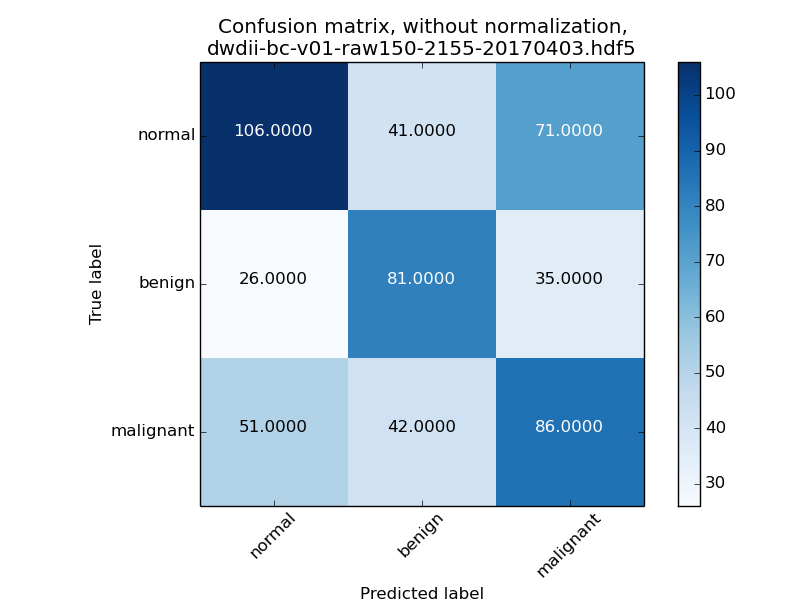

In [27]:
# Load the image we just saved
from IPython.display import Image
Image(filename=fileCfMatrix)

In [28]:
# Plot normalized confusion matrix
fileCfMatrixNorm = '../../figures/confusion_matrix_norm-' + weightsFileName + '.png'
plt.figure()
bc.plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix \n' + weightsFileName)
plt.savefig(fileCfMatrixNorm)

Normalized confusion matrix
[[ 0.49  0.19  0.33]
 [ 0.18  0.57  0.25]
 [ 0.28  0.23  0.48]]


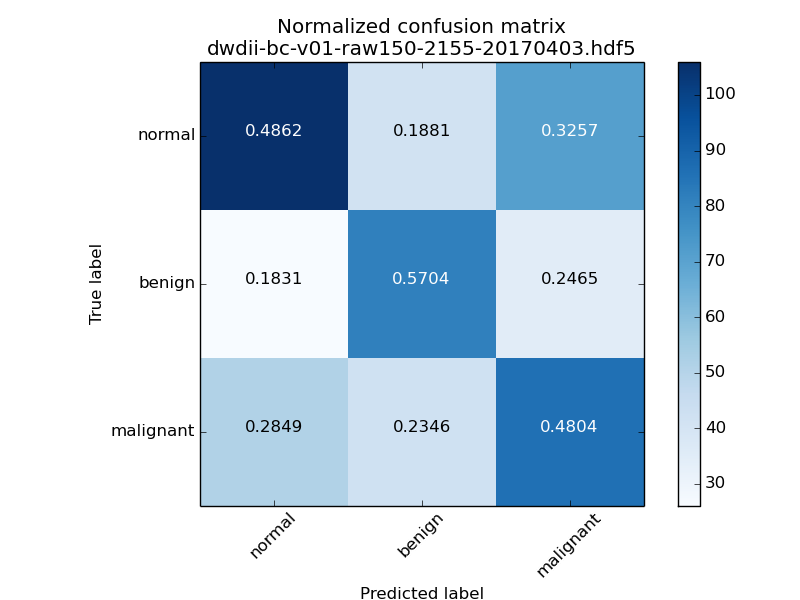

In [29]:
# Load the image we just saved
from IPython.display import Image
Image(filename=fileCfMatrixNorm)